# Individuel

In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from scipy.signal import find_peaks
from matplotlib.animation import FuncAnimation, FFMpegWriter
import json

# Connect to DuckDB 
con = duckdb.connect("football.duckdb")

# Sécurité mémoire
con.execute("PRAGMA threads=4;")
con.execute("PRAGMA memory_limit='4GB';")

print("DuckDB ready")

con.execute("""
CREATE OR REPLACE TABLE summary AS
SELECT *
FROM read_csv_auto('data/summary.csv')
""")

DuckDB ready


In [111]:
#Afficher colonnes de la table tracking_games
print(con.execute("PRAGMA table_info('tracking_games');").fetchdf())

   cid           name       type  notnull dflt_value     pk
0    0  player_pseudo     BIGINT    False       None  False
1    1   session_type    VARCHAR    False       None  False
2    2   session_date       DATE    False       None  False
3    3      sensor_id    INTEGER    False       None  False
4    4       time_utc  TIMESTAMP    False       None  False
5    5          x_pos     DOUBLE    False       None  False
6    6          y_pos     DOUBLE    False       None  False
7    7      speed_kmh     DOUBLE    False       None  False


## Tableau de zone

In [69]:
def speed_zone(player, month):
    # Récupérer la vitesse max du joueur sur le mois
    df_speed = con.execute(f"""
    SELECT
        strftime('%Y-%m', session_date) AS month,
        player_pseudo,
        MAX(speed_kmh) AS max_speed_kmh
    FROM tracking_games
    WHERE player_pseudo = '{player}'
    AND strftime('%Y-%m', session_date) = '{month}'
    GROUP BY month, player_pseudo
    """).df()
    
    if df_speed.empty:
        raise ValueError(f"Aucune donnée pour le joueur {player} sur le mois {month}")
    
    vmax = df_speed['max_speed_kmh'].values[0]

    # Définition des zones
    zones = [0,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    labels = [
        '0-40%',
        '40-50%',
        '50-60%',
        '60-70%',
        '70-80%',
        '80-90%',
        '90-100%'
    ]

    df_zone = pd.DataFrame({
        'zone': labels,
        'min_speed_kmh': [vmax * z1 for z1 in zones[:-1]],
        'max_speed_kmh': [vmax * z2 for z2 in zones[1:]],
    })
    return df_zone

# Exemple d'utilisation
player_pseudo = 6
month = '2020-03'
df_zone_player = speed_zone(player_pseudo, month)
df_zone_player


,zone,min_speed_kmh,max_speed_kmh
0,0-40%,0.000000,12.444048
1,40-50%,12.444048,15.555060
2,50-60%,15.555060,18.666072
3,60-70%,18.666072,21.777084
4,70-80%,21.777084,24.888096
5,80-90%,24.888096,27.999108
6,90-100%,27.999108,31.110120


## Profile accélération vitesse

Pour tracer le profil, il est proposé, à partir d’une vitesse de 3 m/s, de prendre toutes les 0,2 m/s les deux points dont l’accélération est maximale puis de calculer la droite de régression de l’accélération par rapport à la vitesse.
Miguens et al. [6] proposent une régression quantile dans le cadre du rugby.

In [4]:
#Afficher liste player_pseudo et sensor id  pour la session_date '2020-02-01'
con.execute("""
SELECT DISTINCT player_pseudo, sensor_id
FROM tracking_games
WHERE session_date = '2020-02-01'
order by player_pseudo
""").df()


,player_pseudo,sensor_id
0,1,14
1,6,10
2,9,23
3,10,4
4,11,17
5,14,13
6,19,12
7,24,11
8,25,20
9,34,5


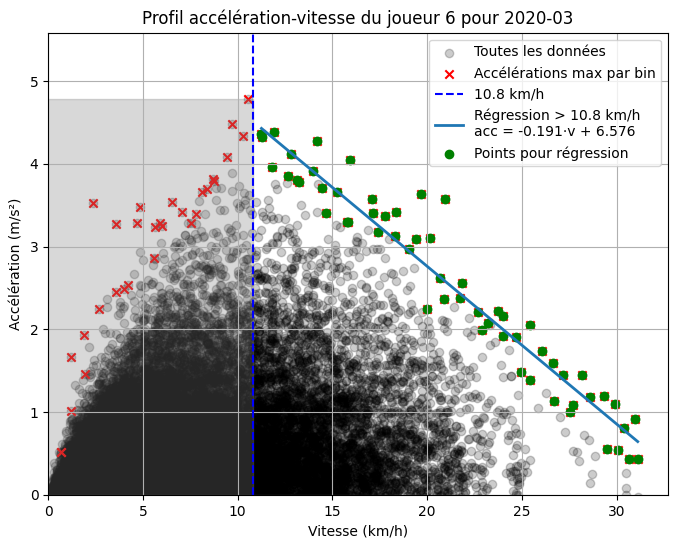

In [70]:
def acceleration_profile(player=None, month='2020-03', fs=10, dt=None, v_start=0, step=0.72, v_threshold=10.8):
    """
    Calcule et trace le profil accélération-vitesse pour tous les matchs du mois.
    player: int ou str, pseudo du joueur à filtrer. Si None, prend tous les joueurs.
    month: str, format 'YYYY-MM'
    fs: fréquence d'échantillonnage
    dt: intervalle de temps, calculé par défaut si None
    v_start: vitesse minimale pour les bins
    step: taille du bin en km/h
    v_threshold: seuil pour la régression
    """
    dt = dt or 1 / fs

    # Récupération des données
    query = f"""
    SELECT *
    FROM tracking_games
    WHERE strftime('%Y-%m', session_date) = '{month}'
    """
    if player is not None:
        query += f" AND player_pseudo = {player}"

    query += " ORDER BY player_pseudo, session_date, time_utc"

    df = con.execute(query).df()

    if df.empty:
        raise ValueError(f"Aucune donnée pour le joueur {player} sur le mois {month}")

    # Calcul vitesse m/s et accélération
    df['speed_ms'] = df['speed_kmh'] / 3.6
    df['acceleration'] = df['speed_ms'].diff() / dt

    # Filtrage des vitesses >= v_start
    df = df[df['speed_kmh'] >= v_start].copy()
    if df.empty:
        raise ValueError("Pas de vitesses supérieures ou égales à v_start")

    # Création des bins
    v_max = df['speed_kmh'].max()
    bins = np.arange(v_start, v_max + step, step) if v_max > v_start else np.array([v_start, v_start + step])
    df['speed_bin'] = pd.cut(df['speed_kmh'], bins=bins, include_lowest=True)

    # Sélection des accélérations max par bin
    df_max_acc = (
        df.sort_values('acceleration', ascending=False)
          .groupby('speed_bin')
          .head(2)
          .dropna(subset=['speed_bin'])
    )

    # Filtrage pour la régression
    df_reg = df_max_acc[df_max_acc['speed_kmh'] >= v_threshold].copy()
    df_reg = df_reg.dropna(subset=['speed_kmh', 'acceleration'])
    if df_reg.empty:
        raise ValueError("Aucun point disponible pour la régression (> v_threshold)")

    # Régression linéaire
    coef = np.polyfit(df_reg['speed_kmh'], df_reg['acceleration'], 1)
    a, b = coef
    v_line = np.linspace(df_reg['speed_kmh'].min(), df_reg['speed_kmh'].max(), 100)
    acc_line = a * v_line + b

    # Tracé
    plt.figure(figsize=(8, 6))
    plt.scatter(df['speed_kmh'], df['acceleration'], alpha=0.2, color='black', label='Toutes les données')
    plt.scatter(df_max_acc['speed_kmh'], df_max_acc['acceleration'], marker='x', color='red', label='Accélérations max par bin')
    plt.axvline(x=v_threshold, color='blue', linestyle='--', label=f'{v_threshold} km/h')
    plt.fill_betweenx(y=[df['acceleration'].min(), df['acceleration'].max()],
                      x1=-1, x2=v_threshold, color='gray', alpha=0.3)
    plt.plot(v_line, acc_line, linestyle='-', linewidth=2,
             label=f"Régression > {v_threshold} km/h\nacc = {a:.3f}·v + {b:.3f}")
    plt.scatter(df_reg['speed_kmh'], df_reg['acceleration'], marker='o', color='green', label='Points pour régression')
    plt.xlabel('Vitesse (km/h)')
    plt.ylabel('Accélération (m/s²)')
    plt.xlim(0)
    plt.ylim(0)
    title_player = f"du joueur {player}" if player else "de tous les joueurs"
    plt.title(f'Profil accélération-vitesse {title_player} pour {month}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemple d'utilisation
acceleration_profile(player=6, month='2020-03')


## Metrics

In [4]:
# ===============================
# Paramètres
# ===============================
month = '2020-03'          # Format YYYY-MM pour le mois ciblé
session_type = 'game'
fs = 10                    # Hz
dt = 1 / fs
player_selected = None      # mettre le pseudo du joueur pour filtrer, sinon None pour tous

# ===============================
# Récupérer tous les matchs du mois
# ===============================
df_match = con.execute(f"""
SELECT
    t.player_pseudo,
    t.sensor_id,
    s.position,
    t.session_date
FROM tracking_games t
INNER JOIN summary s
    ON t.sensor_id = s.Sensor
    AND DATE(s.date) = t.session_date
WHERE CAST(t.session_date AS VARCHAR) LIKE '{month}-%'
AND t.session_type = '{session_type}'
GROUP BY t.player_pseudo, t.sensor_id, s.position, t.session_date
ORDER BY t.player_pseudo, t.session_date
""").df()

if df_match.empty:
    raise ValueError(f"Aucun match trouvé pour le mois {month}")

# Filtrer sur un joueur si demandé
if player_selected is not None:
    df_match = df_match[df_match['player_pseudo'] == player_selected]
    if df_match.empty:
        raise ValueError(f"Aucun match pour le joueur {player_selected} ce mois-ci")

# ===============================
# Fonction de calcul des metrics
# ===============================
def compute_metrics(df_player):
    df_player = df_player.sort_values('time_utc')
    
    # Distance totale
    df_player['dist'] = np.sqrt(df_player['x_pos'].diff()**2 + df_player['y_pos'].diff()**2)
    max_distance = float(df_player['dist'].sum())
    
    # Accélération
    df_player['speed_ms'] = df_player['speed_kmh'] / 3.6
    df_player['acceleration'] = df_player['speed_ms'].diff() / dt
    
    # ===============================
    # Pics d'accélération et décélération
    # ===============================
    acc_values = df_player['acceleration'].fillna(0).values
    acc_peaks, _ = find_peaks(acc_values)
    dcc_peaks_all, _ = find_peaks(-acc_values)
    dcc_mask = acc_values[dcc_peaks_all] > -7.5
    dcc_peaks = dcc_peaks_all[dcc_mask]
    dcc_values = acc_values[dcc_peaks]

    Nb_acc_2_5 = int(np.sum(acc_values[acc_peaks] > 2.5))
    Nb_acc_3_5 = int(np.sum(acc_values[acc_peaks] > 3.5))
    Nb_dcc_2_5 = int(np.sum(dcc_values < -2.5))
    Nb_dcc_3_5 = int(np.sum(dcc_values < -3.5))
    max_decceleration = float(dcc_values.min()) if len(dcc_values) > 0 else None
    
    # ===============================
    # Changement de direction > 30°
    # ===============================
    dx = df_player['x_pos'].diff().values
    dy = df_player['y_pos'].diff().values
    vectors = np.column_stack((dx[1:], dy[1:]))
    angles = []
    for i in range(len(vectors)-1):
        v1, v2 = vectors[i], vectors[i+1]
        norm1, norm2 = np.linalg.norm(v1), np.linalg.norm(v2)
        if norm1 == 0 or norm2 == 0:
            angles.append(0)
            continue
        cos_theta = np.dot(v1, v2) / (norm1 * norm2)
        cos_theta = np.clip(cos_theta, -1, 1)
        theta = np.arccos(cos_theta) * 180 / np.pi
        angles.append(theta)
    angles = np.array(angles)
    Nb_direction_changes = int(np.sum(angles > 30))
    
    # ===============================
    # Time played
    # ===============================
    time_played = df_player['time_utc'].max() - df_player['time_utc'].min()
    time_played_seconds = time_played.total_seconds()
    hours = int(time_played_seconds // 3600)
    minutes = int((time_played_seconds % 3600) // 60)
    seconds = int(time_played_seconds % 60)
    time_played_hms = f"{hours:02d}:{minutes:02d}:{seconds:02d}"

    # ===============================
    # Time in Speed zone (en %)
    # ===============================
    # Création des zones de vitesse pour ce joueur
    vmax = df_player['speed_kmh'].max()
    zones = [0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    labels = ['0-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

    df_player['speed_zone'] = pd.cut(
        df_player['speed_kmh'],
        bins=[vmax * z for z in zones],
        labels=labels,
        include_lowest=True
    )

    # Compter le nombre de frames dans chaque zone et convertir en %
    zone_counts = df_player['speed_zone'].value_counts(normalize=True) * 100

    # ===============================
    # Training Load normalisé
    # ===============================
    zone_coeffs = {
        '0-40%': 1,
        '40-50%': 2,
        '50-60%': 3,
        '60-70%': 4,
        '70-80%': 5,
        '80-90%': 6,
        '90-100%': 7
    }

    training_load = sum(zone_counts.get(label, 0) * zone_coeffs[label] for label in labels)
    training_load_normalized = training_load / 100  # normalisation sur 100%

    # ===============================
    # Metrics principales avec zones
    # ===============================
    metrics = {
        'max_speed': float(df_player['speed_kmh'].max()) if not df_player['speed_kmh'].empty else None,
        'max_distance': max_distance,
        'max_acceleration': float(df_player['acceleration'].max()),
        'max_decceleration': max_decceleration,
        'max_direction_changes': Nb_direction_changes,
        'Nb_acc_2_5': Nb_acc_2_5,
        'Nb_acc_3_5': Nb_acc_3_5,
        'Nb_dcc_2_5': Nb_dcc_2_5,
        'Nb_dcc_3_5': Nb_dcc_3_5,
        'time_played_hms': time_played_hms,
        'training_load': round(training_load_normalized, 2)  # Ajout directement ici
    }

    # Ajouter les pourcentages de temps par zone
    for label in labels:
        metrics[f'time_in_zone_{label}'] = round(zone_counts.get(label, 0), 2)
    
    return metrics

# ===============================
# Calculer metrics pour chaque joueur et chaque match
# ===============================
metrics_rows = []
for idx, row in df_match.iterrows():
    player = row['player_pseudo']
    session_date = row['session_date']
    
    df_player = con.execute(f"""
        SELECT *
        FROM tracking_games
        WHERE session_date = '{session_date}'
        AND session_type = '{session_type}'
        AND player_pseudo = {player}
    """).df()
    
    metrics = compute_metrics(df_player)
    metrics['player_pseudo'] = player
    metrics['session_date'] = session_date
    metrics_rows.append(metrics)

# ===============================
# Convertir en DataFrame et créer la table
# ===============================
df_metrics = pd.DataFrame(metrics_rows)
table_name = f"{session_type}_metrics_{month.replace('-', '_')}"
con.execute(f"CREATE OR REPLACE TABLE {table_name} AS SELECT * FROM df_metrics")
print(f"Table '{table_name}' créée/replacée avec succès !")


Table 'game_metrics_2020_03' créée/replacée avec succès !


In [5]:
#Afficher la table game_2020_03
con.execute("SELECT * FROM game_metrics_2020_03").df()

,max_speed,max_distance,max_acceleration,max_decceleration,max_direction_changes,Nb_acc_2_5,Nb_acc_3_5,Nb_dcc_2_5,Nb_dcc_3_5,time_played_hms,training_load,time_in_zone_0-40%,time_in_zone_40-50%,time_in_zone_50-60%,time_in_zone_60-70%,time_in_zone_70-80%,time_in_zone_80-90%,time_in_zone_90-100%,player_pseudo,session_date
0,24.23520,6072.959619,4.411,-5.010,2254,57,6,93,9,00:45:25,1.68,65.39,15.11,10.47,5.50,2.41,0.81,0.32,1,2020-03-03
1,25.52328,5250.231637,4.807,-6.172,4234,91,13,120,30,00:45:18,1.40,79.84,9.00,5.83,3.26,1.32,0.60,0.16,4,2020-03-03
2,27.19692,3145.992339,4.920,-5.454,2943,59,9,96,18,00:26:59,1.39,80.90,8.61,5.20,2.38,1.94,0.75,0.22,4,2020-03-07
3,28.58580,8107.300847,4.782,-5.522,11597,115,19,136,36,01:27:16,1.24,86.51,6.63,4.00,1.88,0.73,0.21,0.03,6,2020-03-03
4,31.11012,2966.804333,4.481,-5.055,3799,53,7,56,16,00:26:59,1.23,87.38,6.20,3.56,2.06,0.52,0.12,0.16,6,2020-03-07
5,30.41856,5697.057863,3.916,-5.628,3635,79,9,131,44,00:45:18,1.32,82.83,8.48,4.69,2.25,1.23,0.40,0.11,9,2020-03-03
6,29.00808,5799.550224,5.670,-4.963,2695,70,11,107,26,00:45:17,1.38,77.34,12.76,6.52,2.22,0.77,0.22,0.17,9,2020-03-07
7,24.89040,5354.013347,5.191,-4.598,2993,77,13,92,8,00:45:25,1.45,75.67,11.99,7.07,3.08,1.26,0.54,0.39,10,2020-03-03
8,28.23732,7146.930711,5.697,-4.850,4794,112,15,131,21,01:20:09,1.31,83.03,8.75,4.78,1.91,1.03,0.37,0.13,10,2020-03-07
9,31.04280,8063.078010,5.393,-4.784,7878,127,24,142,30,01:27:06,1.23,87.08,6.75,3.40,1.61,0.84,0.23,0.08,11,2020-03-03


## Radar

In [115]:
month = '2020-03'

df_positions = con.execute(f"""
SELECT DISTINCT
    tg.player_pseudo,
    tg.sensor_id,
    s.position
FROM tracking_games tg
LEFT JOIN summary s
    ON tg.sensor_id = s.Sensor
   AND DATE(tg.session_date) = DATE(s.date)
WHERE strftime('%Y-%m', tg.session_date) = '{month}'
ORDER BY tg.player_pseudo
""").df()

print(df_positions)

    player_pseudo  sensor_id         position
0               1         14  center midfield
1               4         22       right back
2               6         10   center forward
3               9         23      center back
4              10          4      center back
5              11         17       right back
6              12         15  center midfield
7              14         13  center midfield
8              16          3        left back
9              19         12        left back
10             21         18      orik center
11             24         11     left forward
12             25         20   center forward
13             26          6        left back
14             29         28   center forward
15             34          5      center back
16             35         77   center forward
17             36          9       ran center
18             39         21   center forward


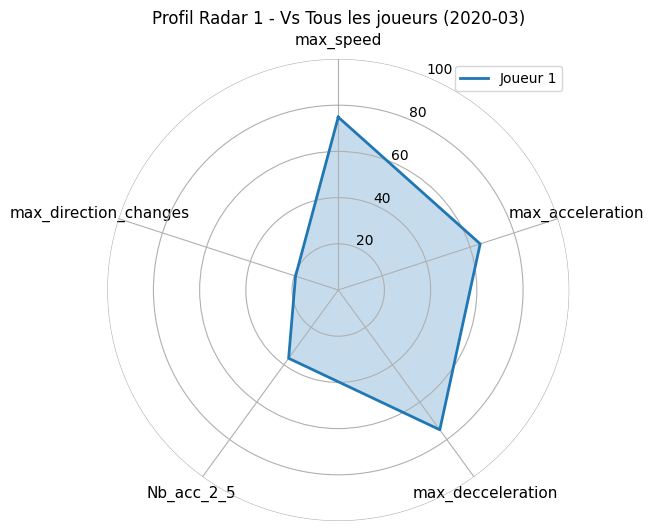

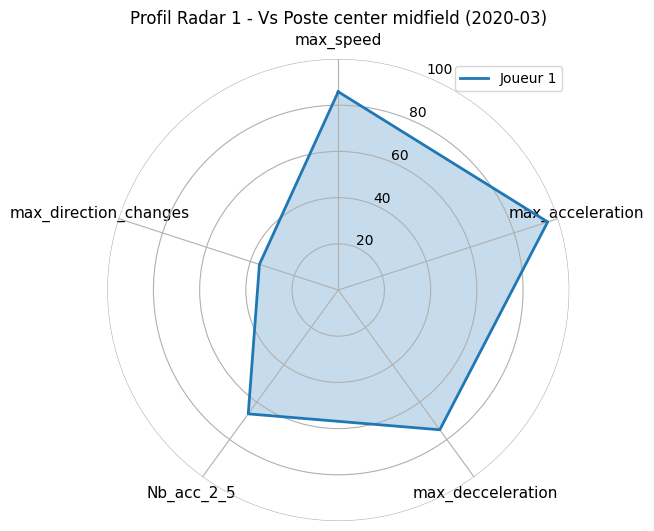

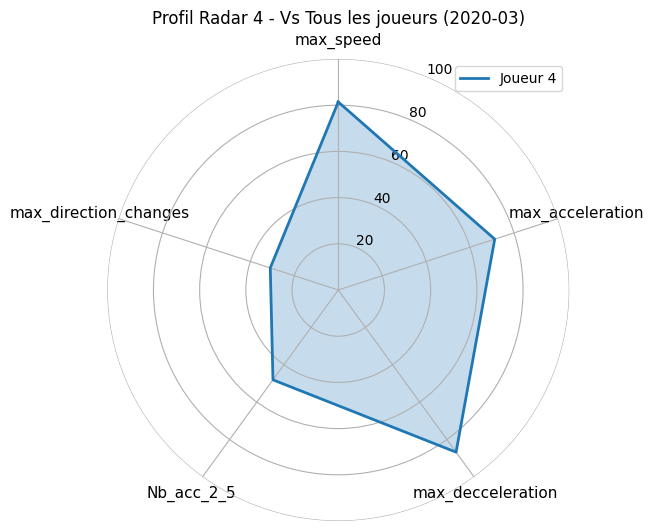

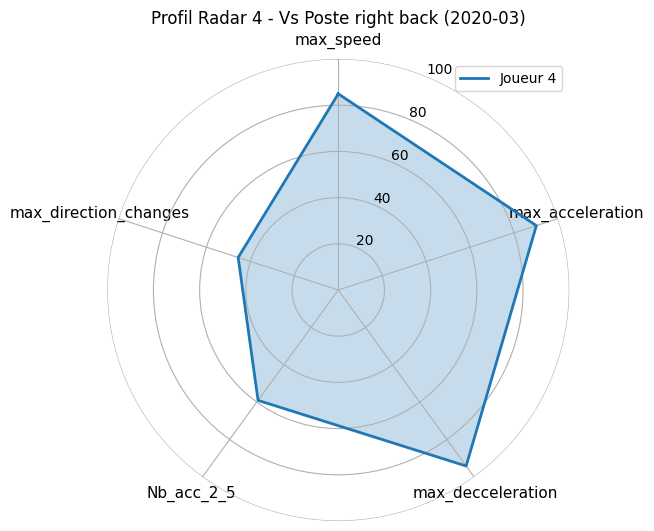

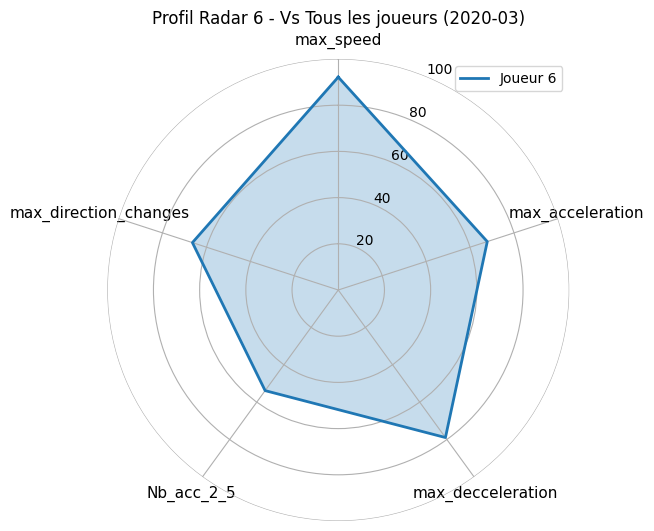

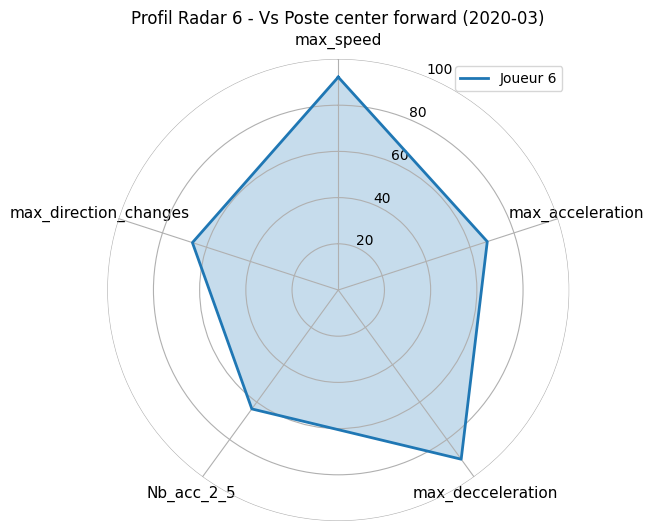

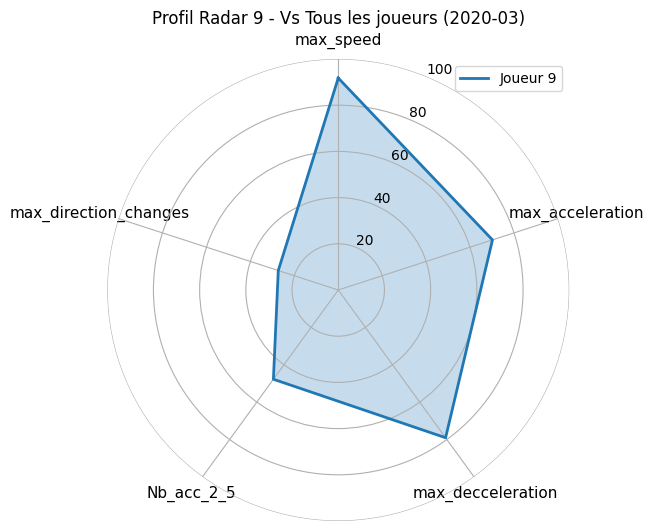

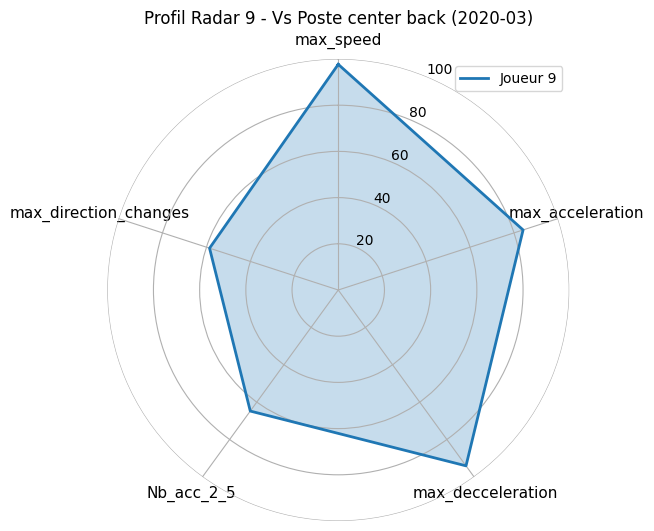

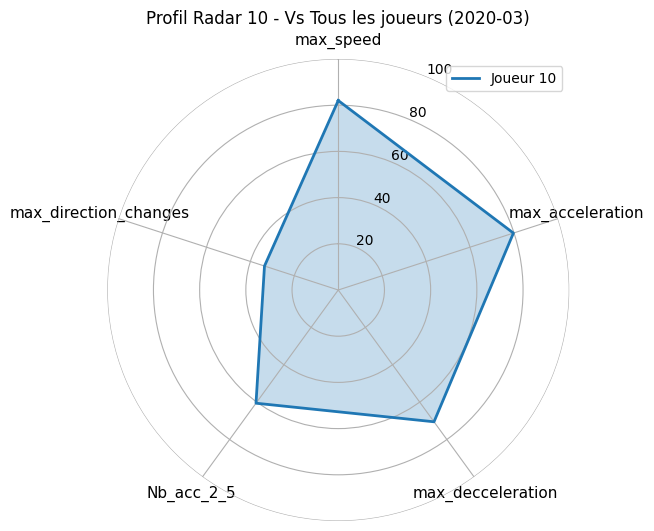

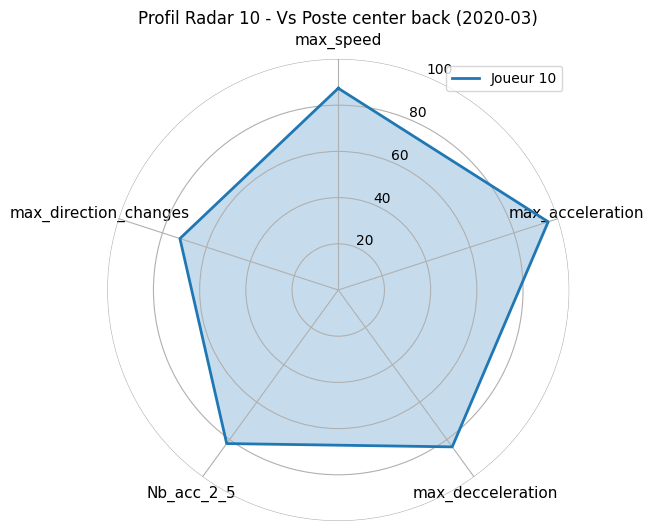

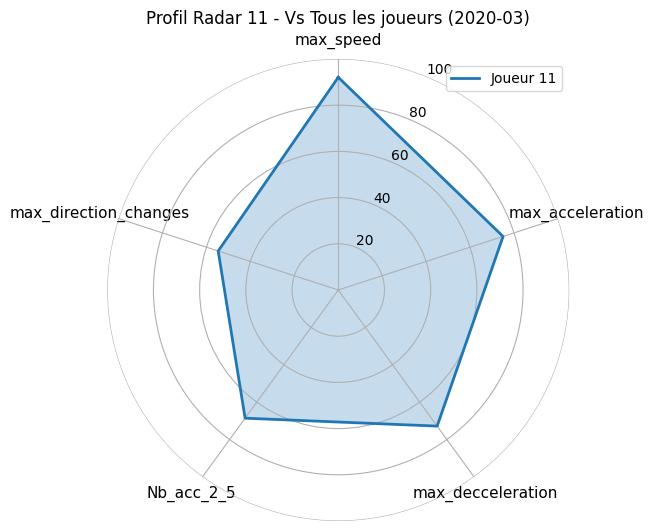

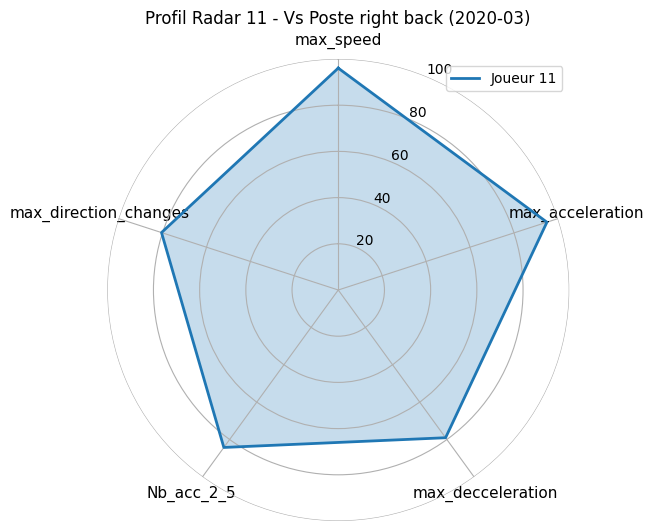

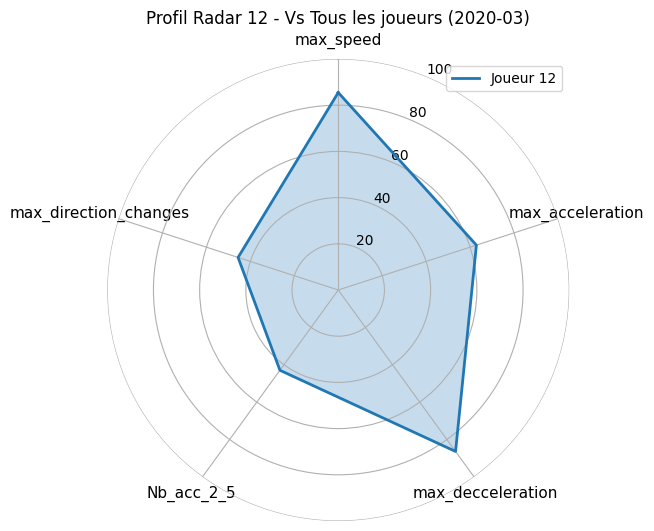

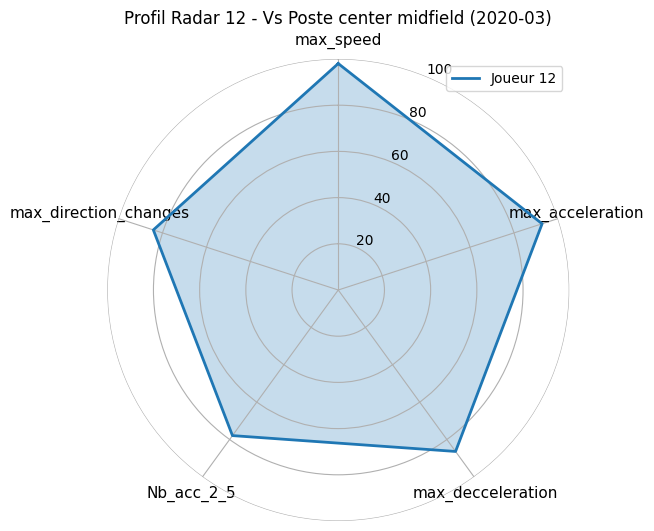

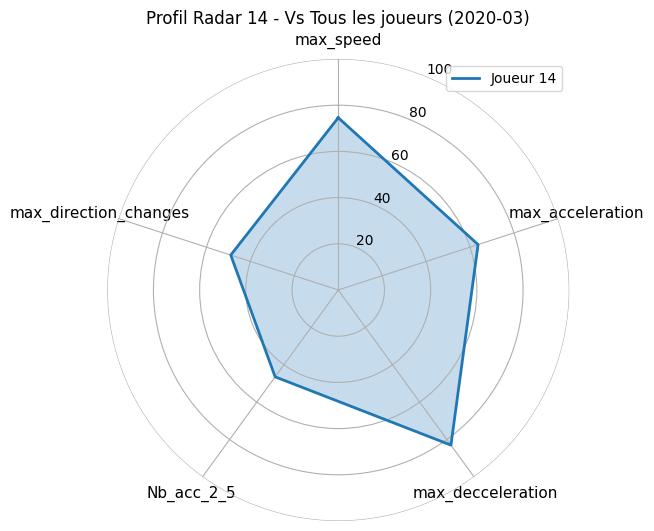

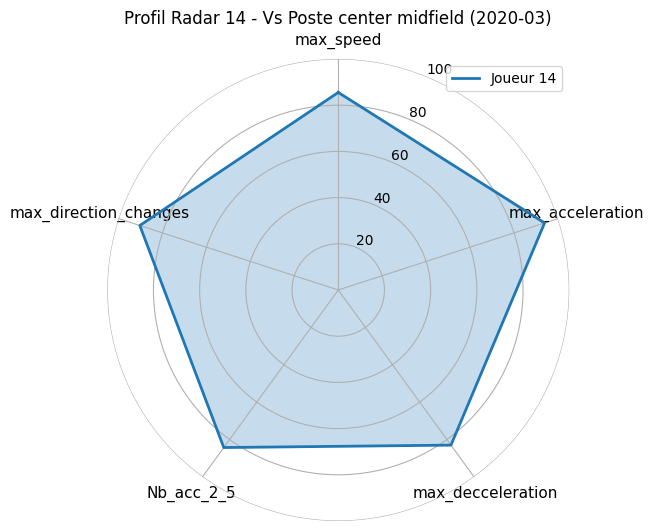

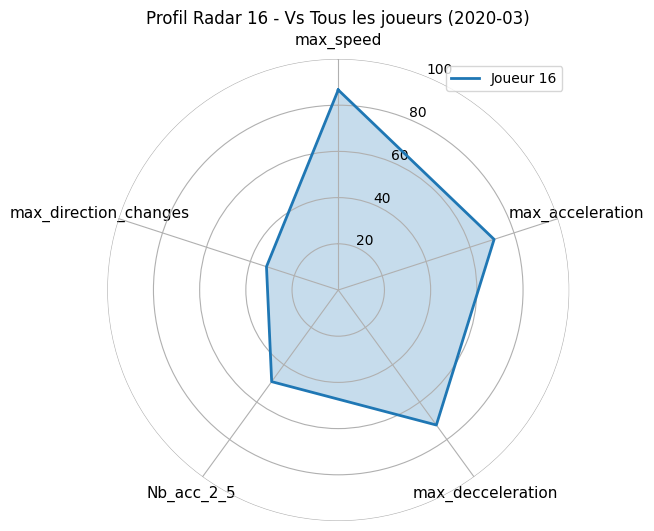

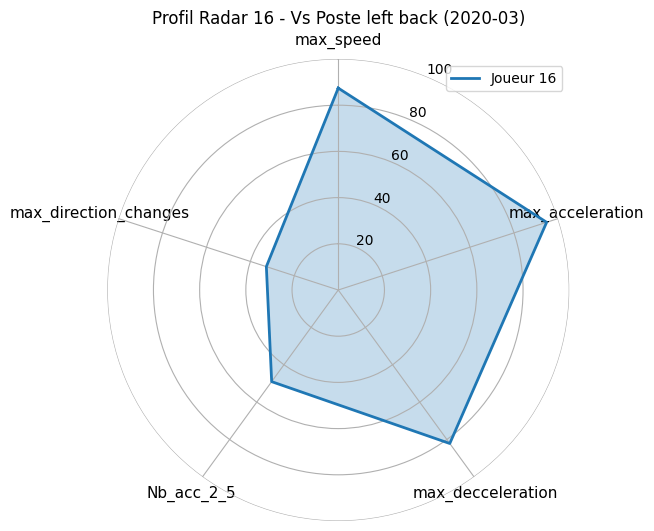

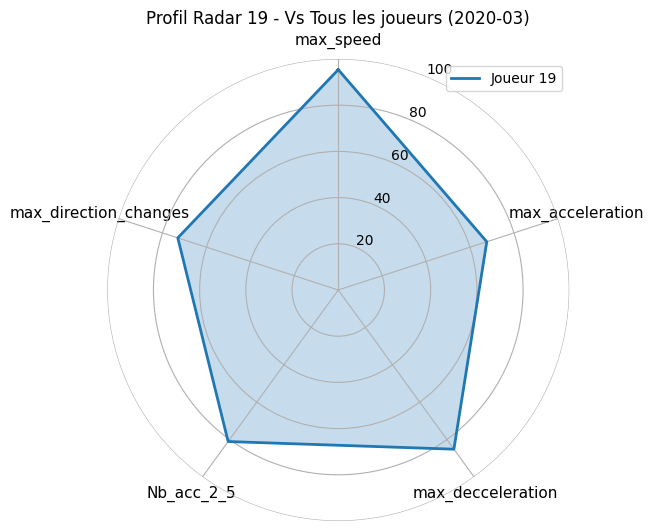

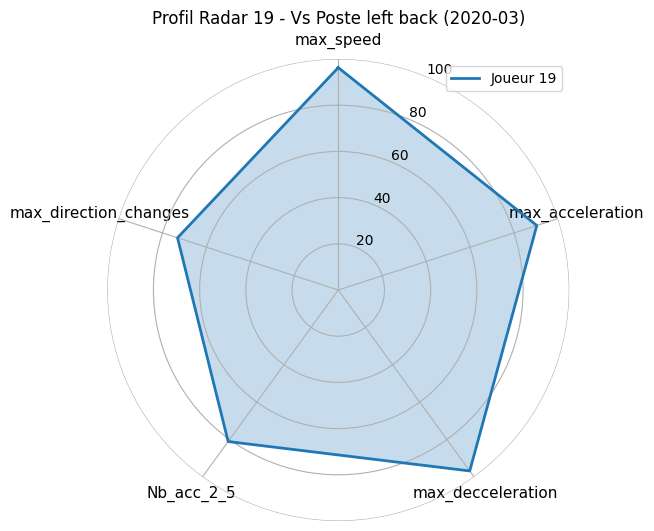

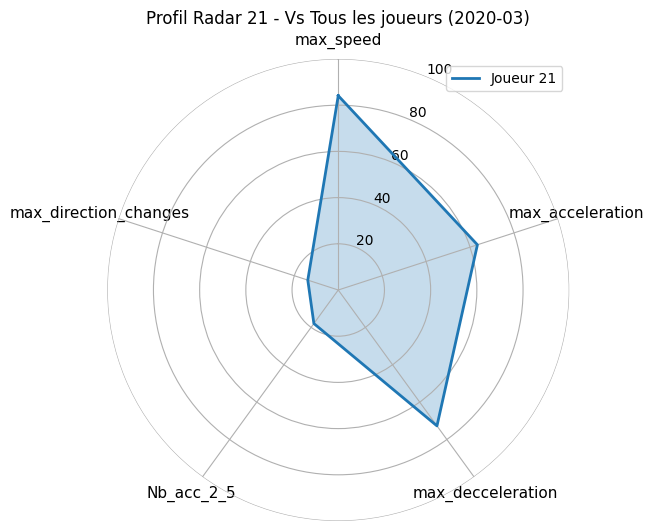

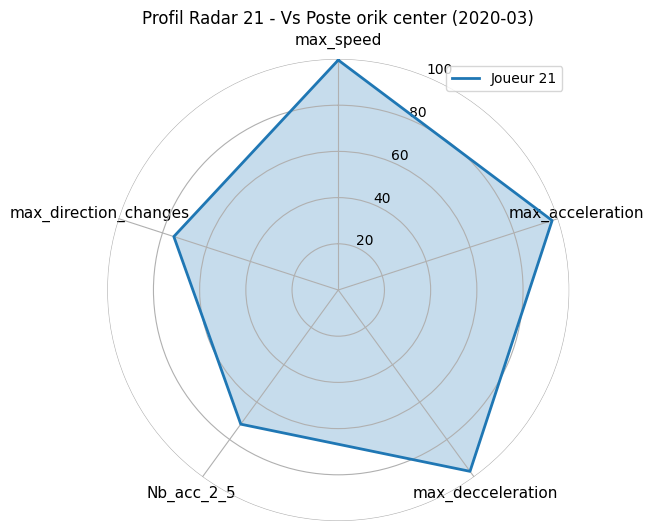

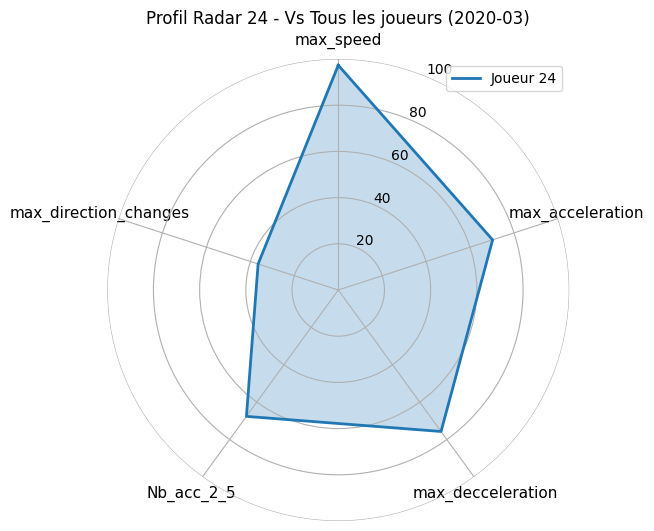

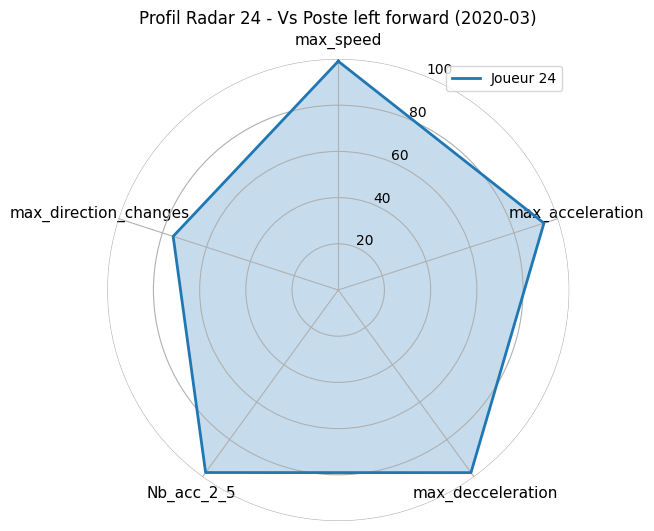

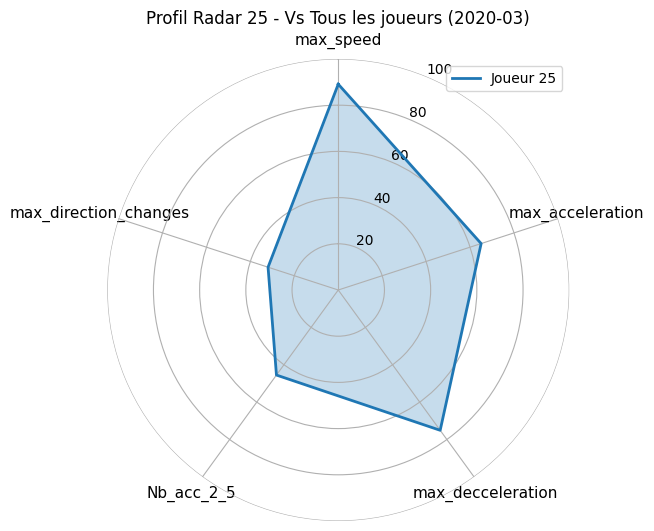

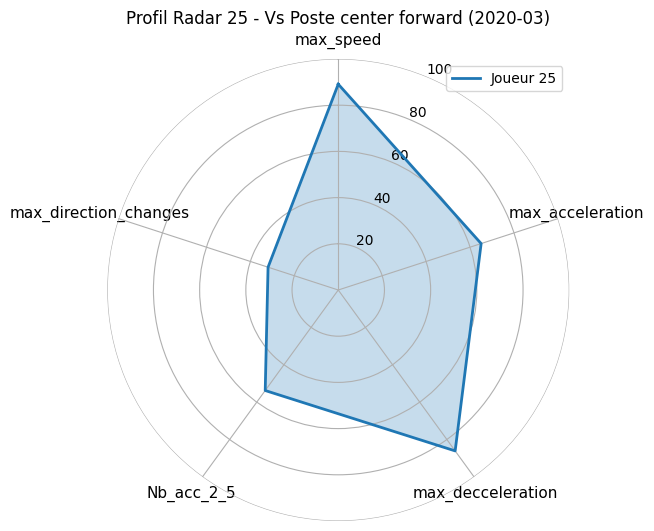

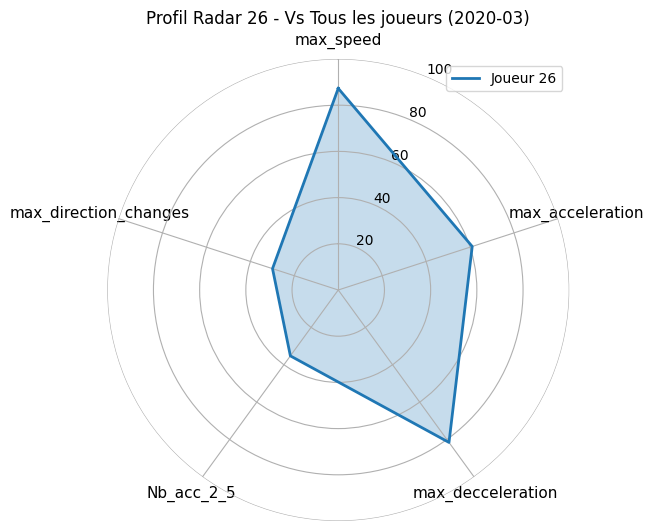

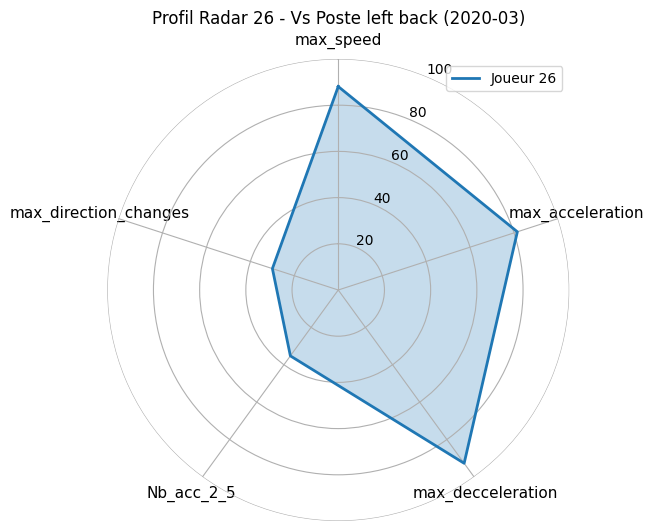

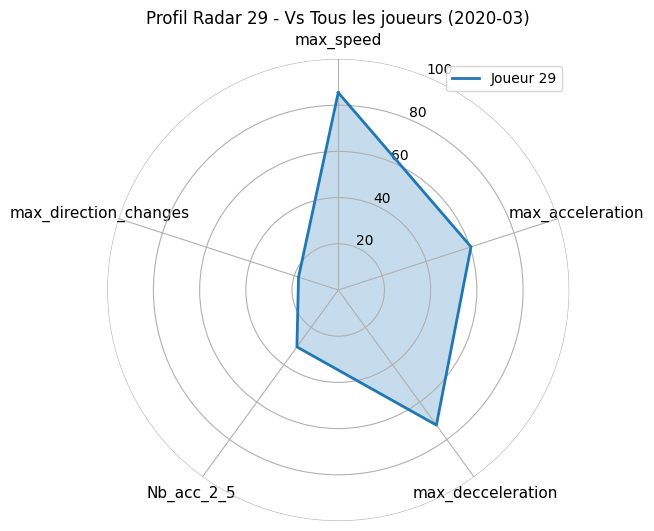

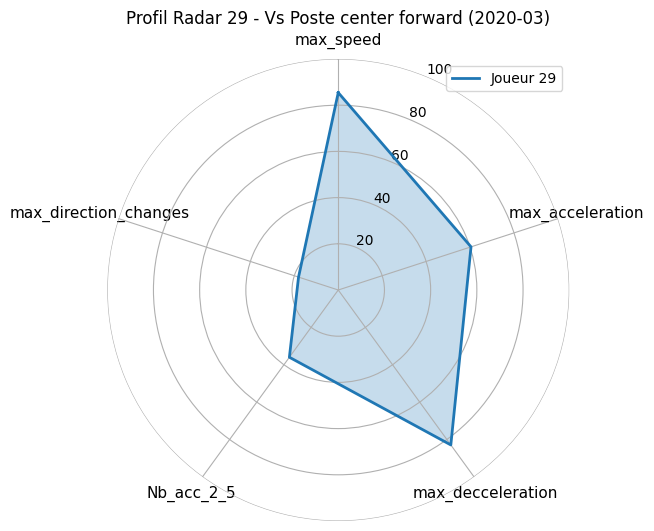

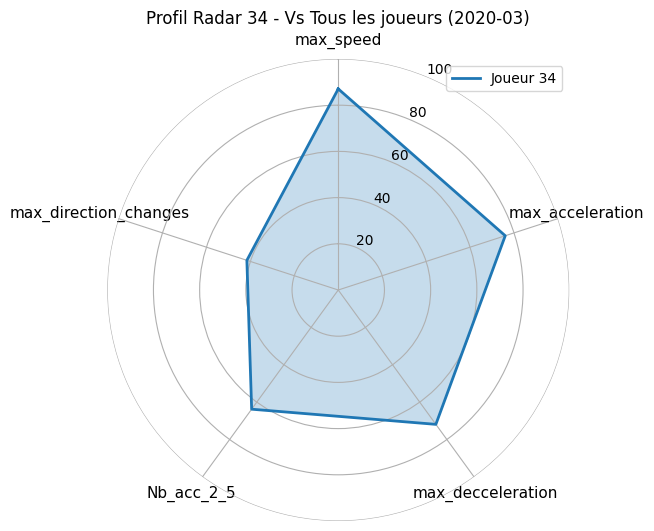

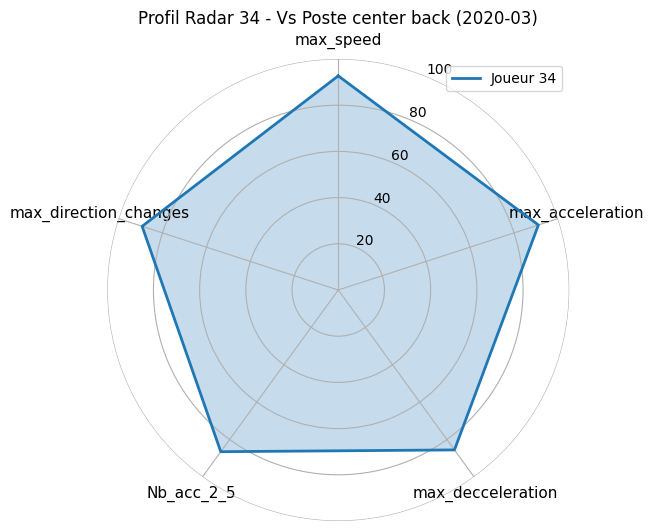

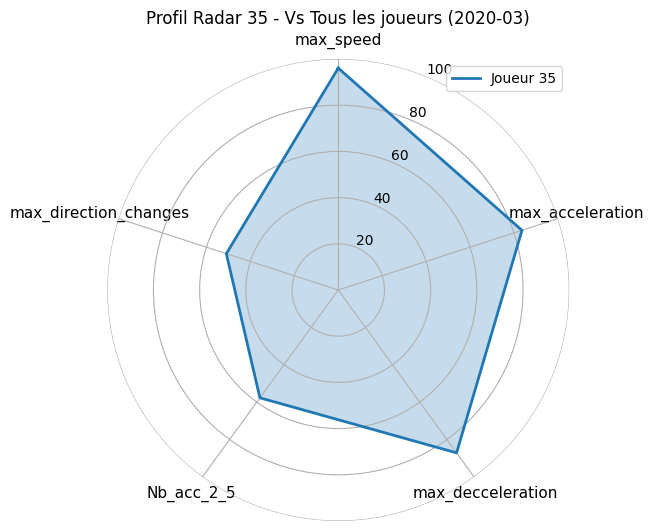

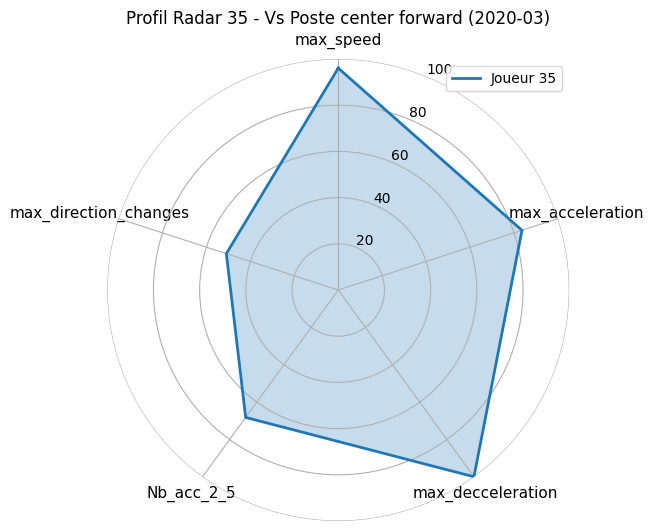

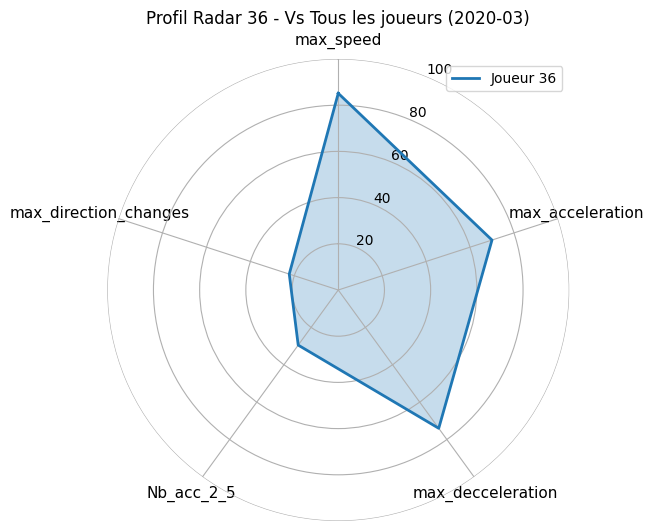

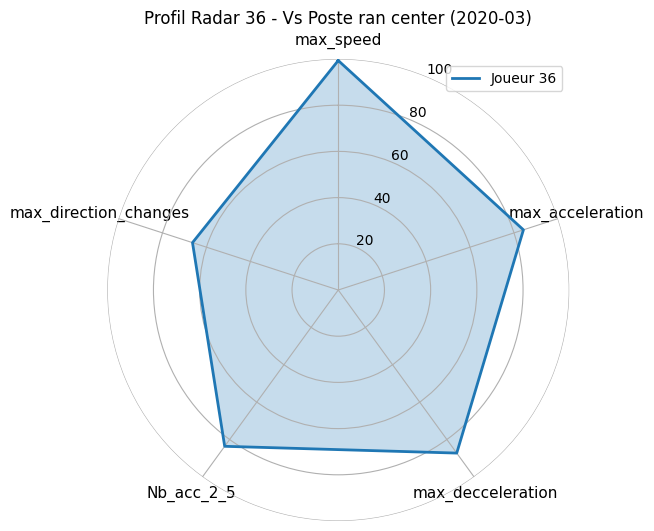

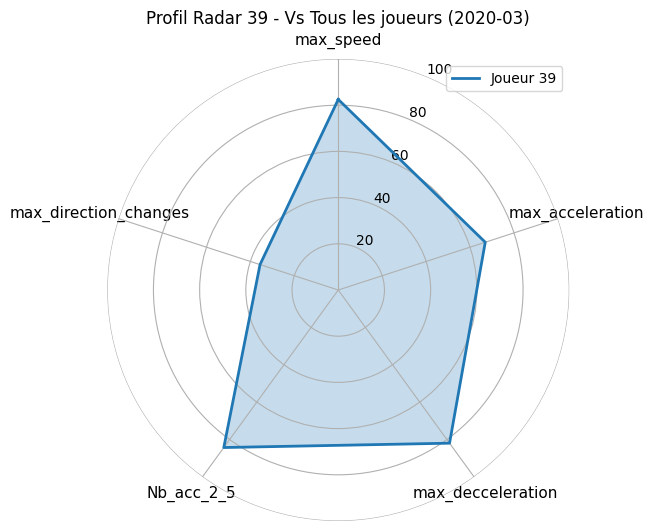

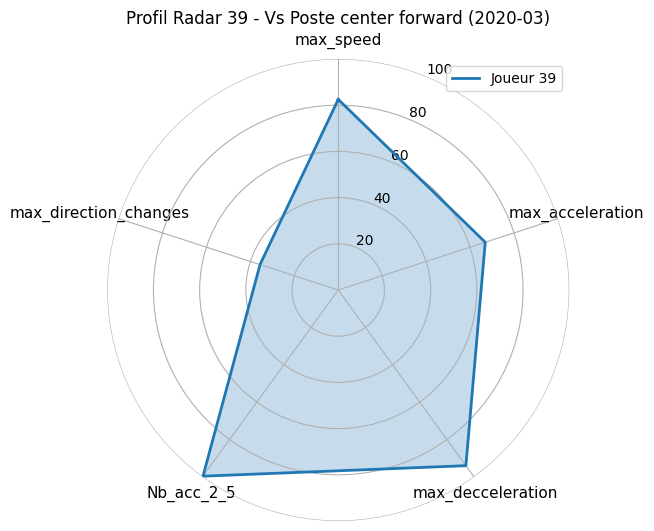

In [145]:
# ===============================
# Paramètres
# ===============================
month = '2020-03'
table_name = f"game_metrics_{month.replace('-', '_')}"
player_selected = None   # None = tous les joueurs

radar_axes = [
    'max_speed',
    'max_acceleration',
    'max_decceleration',
    'Nb_acc_2_5',
    'max_direction_changes'
]

# ===============================
# Récupération données
# ===============================
df_metrics = con.execute(f"SELECT * FROM {table_name}").df()

# ===============================
# Récupération positions
# ===============================
df_positions = con.execute(f"""
SELECT DISTINCT
    tg.player_pseudo,
    s.position
FROM tracking_games tg
LEFT JOIN summary s
    ON tg.sensor_id = s.Sensor
   AND DATE(tg.session_date) = DATE(s.date)
WHERE strftime('%Y-%m', tg.session_date) = '{month}'
""").df()

df_metrics = df_metrics.merge(df_positions, on='player_pseudo', how='left')

# ===============================
# Filtrer joueur si besoin
# ===============================
if player_selected is not None:
    players = [player_selected] if isinstance(player_selected, int) else list(player_selected)
    df_metrics = df_metrics[df_metrics['player_pseudo'].isin(players)]
    if df_metrics.empty:
        raise ValueError(f"Aucun match pour le joueur {player_selected}")

# ===============================
# Fonction normalisation
# ===============================
def normalize_df(df_source):

    df_norm = df_source.copy()

    for col in radar_axes:
        if col == 'max_decceleration':
            max_val = df_source[col].abs().max()
            df_norm[col] = df_source[col].abs() / max_val * 100 if max_val > 0 else 0
        else:
            max_val = df_source[col].max()
            df_norm[col] = df_source[col] / max_val * 100 if max_val > 0 else 0

    return df_norm

# ===============================
# Fonction radar
# ===============================
def plot_radar(player, df_norm, title_suffix):

    categories = radar_axes
    N = len(categories)

    values = df_norm[df_norm['player_pseudo'] == player][categories].mean().tolist()
    values += values[:1]

    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)

    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, size=11)

    ax.set_yticks([20,40,60,80,100])
    ax.set_ylim(0,100)

    ax.spines['polar'].set_visible(False)

    ax.plot(angles, values, linewidth=2, label=f'Joueur {player}')
    ax.fill(angles, values, alpha=0.25)

    plt.title(f'Profil Radar {player} - {title_suffix} ({month})')
    plt.legend(loc='upper right')
    plt.show()

# ===============================
# Création radar
# ===============================
players_to_plot = df_metrics['player_pseudo'].unique()

for player in players_to_plot:

    # ---------- Radar 1 : Tous les joueurs ----------
    df_norm_all = normalize_df(df_metrics)
    plot_radar(player, df_norm_all, "Vs Tous les joueurs")

    # ---------- Radar 2 : Même poste ----------
    poste = df_metrics[df_metrics['player_pseudo'] == player]['position'].values[0]
    df_poste = df_metrics[df_metrics['position'] == poste]

    df_norm_poste = normalize_df(df_poste)
    plot_radar(player, df_norm_poste, f"Vs Poste {poste}")

In [6]:
#Ferme session DuckDB
con.close()